In [1]:
import pandas as pd
dataset = pd.read_csv("../../Data/cleaned_v1.csv")
dataset

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Content,Label,Content_cleaned,content_cleaned_v1,Length_content_cleaned,Content_cleaned_v1,Content_cleaned_v2,Length_cleaned_v1,Length_cleaned_v2
0,0,0,0,0,Sao Việt ngày 29/3: NSƯT Chí Trung cùng bạn gá...,entertainment,việt nsưt chí_trung gái đi du_lịch mỹ ...,sao việt ngày nsưt chí_trung cùng bạn gái đi d...,21,sao việt ngày nsưt chí_trung cùng bạn gái đi d...,sao việt nsưt chí_trung bạn gái du_lịch mỹ thờ...,49,33
1,1,1,1,1,Người tiêu dùng trẻ ngày càng có xu hướng chi ...,business,tiêu_dùng trẻ xu_hướng chi_tiêu thông_minh tận...,người tiêu_dùng trẻ ngày_càng có xu_hướng chi_...,311,người tiêu_dùng trẻ ngày_càng có xu_hướng chi_...,tiêu_dùng trẻ ngày_càng xu_hướng chi_tiêu thôn...,510,351
2,2,2,2,2,Trong khuôn viên rất rộng ở khu liên hợp thể t...,sport,khuôn_viên rộng khu liên_hợp thể_thao techo mo...,trong khuôn_viên rất rộng ở khu liên_hợp thể_t...,253,trong khuôn_viên rất rộng khu liên_hợp thể_tha...,khuôn_viên rộng khu liên_hợp thể_thao techo mo...,481,318
3,3,3,3,3,Một trong những triệu chứng điển hình của tiểu...,health,triệu_chứng điển_hình tiểu tần_suất đi_tiểu nư...,một trong những triệu_chứng điển_hình của tiểu...,287,một trong những triệu_chứng điển_hình của tiểu...,triệu_chứng điển_hình tiểu ít tần_suất đi_tiểu...,584,412
4,4,4,4,4,"Từ ngày 27/2-2/3, Hiệp hội golf Việt Nam tổ ch...",sport,hiệp_hội golf việt_nam tổ_chức vòng_lo...,từ ngày hiệp_hội golf việt_nam tổ_chức vòng_lo...,105,từ ngày hiệp_hội golf việt_nam tổ_chức vòng_lo...,hiệp_hội golf tổ_chức vòng_loại tuyển_chọn đội...,157,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24391,24409,24409,24409,24409,"Ở nội dung đôi nam nữ, Trần Ngọc Thúy Vi và Lê...",sport,nội_dung đôi nam_nữ trần_ngọc thúy_vi lê_hoà...,ở nội_dung đôi nam_nữ trần_ngọc thúy_vi và lê_...,149,nội_dung đôi nam_nữ trần_ngọc thúy_vi và lê_ho...,nội_dung đôi nam_nữ trần_ngọc thúy_vi lê_hoàng...,284,175
24392,24410,24410,24410,24410,Nguồn: Next Sports Thiên Bình,sport,next sports thiên_bình,nguồn next sports thiên_bình,3,nguồn next sports thiên_bình,nguồn next sports thiên_bình,4,4
24393,24411,24411,24411,24411,Nhận định trận đấu giữa Arsenal vs Brighton Tr...,sport,nhận_định trận_đấu arsenal vs brighton khuôn_k...,nhận_định trận_đấu giữa arsenal vs brighton tr...,156,nhận_định trận_đấu giữa arsenal vs brighton tr...,nhận_định trận_đấu giữa arsenal vs brighton kh...,273,194
24394,24412,24412,24412,24412,Dù giành chiến thắng trước Myanmar ở vòng bảng...,sport,giành chiến_thắng myanmar vòng bảng hlv mai_đứ...,dù giành chiến_thắng trước myanmar ở vòng bảng...,138,dù giành chiến_thắng trước myanmar vòng bảng n...,dù giành chiến_thắng myanmar vòng bảng hlv mai...,261,186


In [2]:
from gensim.models import Word2Vec
w2v = Word2Vec.load("../../FeatureEngineering/Vectorize/w2v_300_skip_cleaned_v2.model")

In [3]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences

import numpy as np

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(dataset['Content_cleaned_v2'])
sequences = tokenizer.texts_to_sequences(dataset['Content_cleaned_v2'])

maxlen = 300
X = sequence.pad_sequences(sequences, maxlen)
# print('X:\n', X[:10])


In [4]:
y = pd.get_dummies(dataset['Label'])
y

,business,education,entertainment,health,politics,sport
0,0,0,1,0,0,0
1,1,0,0,0,0,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
24391,0,0,0,0,0,1
24392,0,0,0,0,0,1
24393,0,0,0,0,0,1
24394,0,0,0,0,0,1


In [5]:
import numpy as np

embedding_dim = 300
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
print('num_words:', num_words)
for word, i in word_index.items():
    if word in w2v.wv.key_to_index:
            embedding_matrix[i] = w2v.wv[word]

num_words: 64326


In [6]:

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional, SimpleRNN, Dropout

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model.add(SimpleRNN(units=300))
model.add(Dropout(0.2))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2023-05-23 18:20:41.702666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 18:21:10.989069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          19297800  
                                                                 
 simple_rnn (SimpleRNN)      (None, 300)               180300    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 19,520,954
Trainable params: 223,154
Non-t

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y , test_size= 0.3, random_state= 42)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((17077, 300), (17077, 6), (7319, 300), (7319, 6))

In [8]:
from keras.callbacks import EarlyStopping
callback1 = EarlyStopping(monitor = "val_accuracy", patience= 4)
callback2 = EarlyStopping(monitor = "val_loss", patience= 4)

In [9]:
model.fit(X_train, Y_train, validation_split=0.1, epochs= 100, callbacks=[callback1, callback2])

Epoch 1/100
481/481 [==============================] - 240s 482ms/step - loss: 0.2814 - accuracy: 0.6253 - val_loss: 0.2673 - val_accuracy: 0.6019
Epoch 2/100
481/481 [==============================] - 230s 479ms/step - loss: 0.2436 - accuracy: 0.6892 - val_loss: 0.2237 - val_accuracy: 0.7535
Epoch 3/100
481/481 [==============================] - 509s 1s/step - loss: 0.2417 - accuracy: 0.6971 - val_loss: 0.4030 - val_accuracy: 0.3015
Epoch 4/100
481/481 [==============================] - 148s 308ms/step - loss: 0.2849 - accuracy: 0.6125 - val_loss: 0.2647 - val_accuracy: 0.6329
Epoch 5/100
481/481 [==============================] - 145s 302ms/step - loss: 0.2909 - accuracy: 0.6060 - val_loss: 0.2414 - val_accuracy: 0.6516
Epoch 6/100
481/481 [==============================] - 147s 305ms/step - loss: 0.2494 - accuracy: 0.6826 - val_loss: 0.3033 - val_accuracy: 0.5773


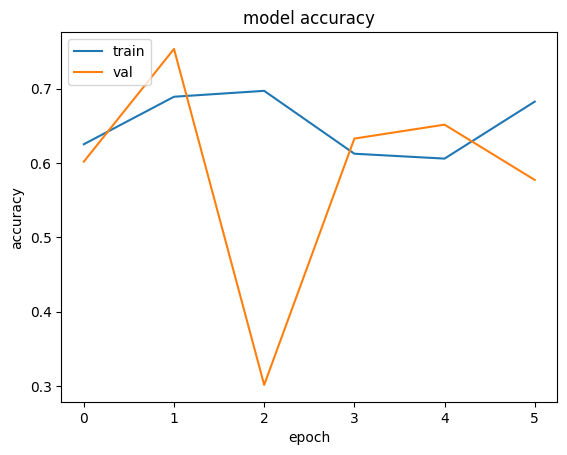

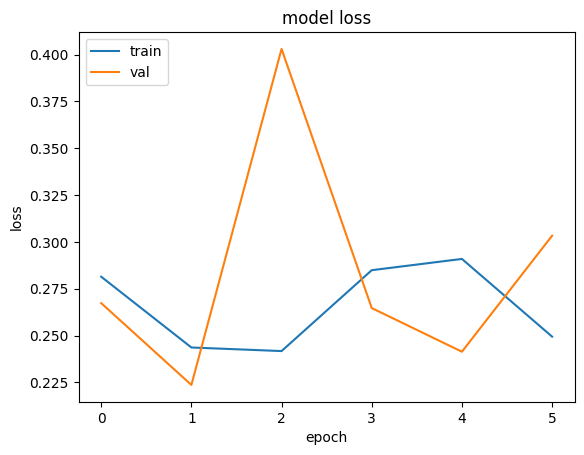

In [10]:
from matplotlib import pyplot as plt
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
from matplotlib import pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

229/229 [==============================] - 31s 134ms/step - loss: 0.2994 - accuracy: 0.5943
Test Loss: 0.29936742782592773
Test Accuracy: 0.5943434834480286


In [12]:
y_pred = model.predict(X_test)

229/229 [==============================] - 33s 142ms/step


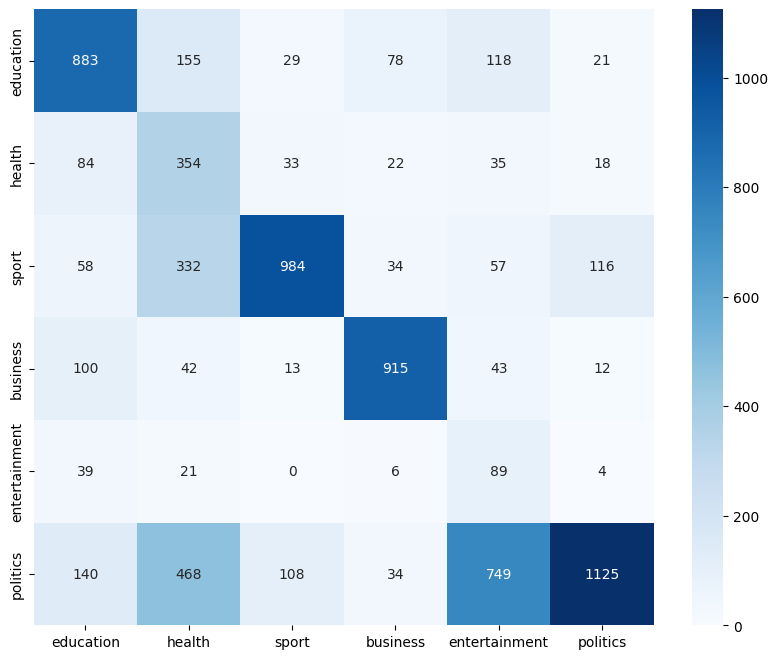

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example classification report data
predicted = y_pred.argmax(axis=1)
true_labels = Y_test.values.argmax(axis=1)

def heatconmat(y_pred, y_test):
  plt.figure(figsize=(10,8))
  cnf_matrix = confusion_matrix(y_pred, y_test)
  ax = sns.heatmap(cnf_matrix, annot=True, fmt='', cmap='Blues')
  ax.xaxis.set_ticklabels(list(set(dataset["Label"])))
  ax.yaxis.set_ticklabels(list(set(dataset["Label"])))
  plt.show()
heatconmat(predicted, true_labels)